# 주제 ①: A/B 버튼 클릭률 비교

## 📋 프로젝트 개요

### 시나리오
- **랜딩 페이지 실험 (A/B Test)**: 사용자에게 A 또는 B 중 하나의 버전을 무작위로 노출
- **클릭 기록**: 사용자가 버튼을 클릭하면 `1`, 클릭하지 않으면 `0`으로 기록

### 사용 데이터
- `model_accuracy_practice.csv`: 모델 예측 결과 데이터
- `user_data.csv`: 사용자 정보 데이터

### 분석 목표
- A그룹 클릭률 vs B그룹 클릭률 비교
- 두 비율 차이의 95% 신뢰구간 계산
- 통계적 유의성 검정 및 해석

---

## 🔄 공통 분석 플로우

이 프로젝트는 다음 5단계로 진행됩니다:

1. **주제 선택** ✅ (A/B 테스트 선택 완료)
2. **데이터 구조 이해** (변수 타입, 0/1 의미 파악)
3. **기초 통계 & 시각화** (비율 계산, 막대그래프)
4. **신뢰구간 계산** (95% CI 및 차이 해석)
5. **결과 요약** (인사이트 도출)

---

## 📦 팀 산출물

- ✅ **파이썬 노트북 (.ipynb)**: 분석 코드 및 주석 포함 (본 파일)
- 📊 **요약 슬라이드 (1~2장)**: 핵심 결과 및 결론 위주
- 🎤 **팀별 발표 (3~5분)**: 분석 과정과 결론 공유

In [82]:
# ============================================================================
# 라이브러리 Import 및 환경 설정
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from scipy import stats
from scipy.stats import norm
from typing import List

# 한글 폰트 설정
font_list: List[str] = [f.name for f in fm.fontManager.ttflist]
if "Malgun Gothic" in font_list:
    plt.rcParams["font.family"] = "Malgun Gothic"
elif "AppleGothic" in font_list:
    plt.rcParams["font.family"] = "AppleGothic"
else:
    plt.rcParams["font.family"] = "DejaVu Sans"

plt.rcParams["axes.unicode_minus"] = False  # 마이너스 기호 깨짐 방지

print("✅ 라이브러리 import 완료")

---

## 2단계: 데이터 구조 이해 (변수 타입, 0/1 의미)

이 단계에서는 데이터의 구조를 파악하고, 각 변수의 의미와 타입을 이해합니다.

In [83]:
# ============================================================================
# 2단계: 데이터 구조 이해
# ============================================================================

# 데이터 로드
model_data = pd.read_csv("model_accuracy_practice.csv")
user_data = pd.read_csv("user_data.csv")

print("=" * 70)
print("📊 원본 데이터 확인")
print("=" * 70)

print("\n[1] 모델 정확도 데이터 (model_accuracy_practice.csv)")
print(f"   - 데이터 크기: {model_data.shape[0]}행 × {model_data.shape[1]}열")
print(f"   - 컬럼: {list(model_data.columns)}")
print("\n   데이터 미리보기:")
print(model_data.head(10))

print("\n   데이터 타입 및 결측치:")
print(model_data.info())

print("\n[2] 사용자 데이터 (user_data.csv)")
print(f"   - 데이터 크기: {user_data.shape[0]}행 × {user_data.shape[1]}열")
print(f"   - 컬럼: {list(user_data.columns)}")
print("\n   데이터 미리보기:")
print(user_data.head(10))

# ============================================================================
# 데이터 변수 의미 이해
# ============================================================================

print("\n" + "=" * 70)
print("🔍 변수 의미 및 데이터 타입 이해")
print("=" * 70)

print("\n[모델 정확도 데이터 변수 설명]")
print("  - id: 사용자 고유 식별자 (정수형)")
print("  - y_true: 실제 정답 (0 또는 1, 범주형)")
print("  - pred_old: 기존 모델 예측값 (0 또는 1, 범주형)")
print("  - pred_new: 신규 모델 예측값 (0 또는 1, 범주형)")
print("  - correct_old: 기존 모델 정확도 (1=정답, 0=오답, 범주형이지만 수치처럼 사용)")
print("  - correct_new: 신규 모델 정확도 (1=정답, 0=오답, 범주형이지만 수치처럼 사용)")

print("\n[0/1 값의 의미]")
print("  - 0: 클릭하지 않음 / 오답 / False")
print("  - 1: 클릭함 / 정답 / True")
print("  - 주의: clicked는 범주형이지만, 비율(평균) 계산을 위해 수치처럼 사용")

# ============================================================================
# A/B 테스트 데이터 구성
# ============================================================================

print("\n" + "=" * 70)
print("🔄 A/B 테스트 데이터 구성")
print("=" * 70)

# 각 사용자를 A 또는 B 그룹에 할당 (id 기반으로 일관성 있게 할당)
# 짝수 id -> A 그룹, 홀수 id -> B 그룹
model_data['group'] = model_data['id'].apply(lambda x: 'A' if x % 2 == 0 else 'B')

# A 그룹은 correct_old를, B 그룹은 correct_new를 클릭 여부로 사용
# 이는 A 그룹이 기존 모델을, B 그룹이 신규 모델을 경험한 것으로 해석
model_data['clicked'] = model_data.apply(
    lambda row: row['correct_old'] if row['group'] == 'A' else row['correct_new'], 
    axis=1
)

# A/B 테스트에 필요한 컬럼만 선택
ab_data = model_data[['id', 'group', 'clicked']].copy()
ab_data = ab_data.rename(columns={'id': 'user_id'})

print("\n[구성된 A/B 테스트 데이터]")
print(f"   - 데이터 크기: {ab_data.shape[0]}행 × {ab_data.shape[1]}열")
print(f"   - 컬럼: {list(ab_data.columns)}")
print("\n   데이터 미리보기:")
print(ab_data.head(10))

print("\n[그룹별 분포]")
print(ab_data['group'].value_counts())
print(f"   - A 그룹: {ab_data[ab_data['group']=='A'].shape[0]}명")
print(f"   - B 그룹: {ab_data[ab_data['group']=='B'].shape[0]}명")

print("\n[클릭 여부 분포]")
print(ab_data['clicked'].value_counts())
print(f"   - 클릭(1): {ab_data[ab_data['clicked']==1].shape[0]}명")
print(f"   - 미클릭(0): {ab_data[ab_data['clicked']==0].shape[0]}명")

print("\n✅ 데이터 구조 이해 완료")

=== 모델 정확도 데이터 ===
데이터 shape: (1500, 6)
   id  y_true  pred_old  pred_new  correct_old  correct_new
0   1       1         1         1            1            1
1   2       0         0         1            1            0
2   3       1         1         1            1            1
3   4       0         0         0            1            1
4   5       0         1         1            0            0
5   6       0         0         0            1            1
6   7       0         0         1            1            0
7   8       0         0         0            1            1
8   9       0         1         0            0            1
9  10       1         1         1            1            1

데이터 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   id           1500 non-null   int64
 1   y_true       1500 non-null   int64
 2   pred_old     1500 no

---

## 3단계: 기초 통계 & 시각화 (비율 계산, 막대그래프)

이 단계에서는 그룹별 클릭률을 계산하고 막대그래프로 시각화합니다.

In [84]:
# ============================================================================
# 3단계: 기초 통계 & 시각화
# ============================================================================

# 그룹별 클릭률 계산
# - count: 각 그룹의 총 사용자 수
# - sum: 각 그룹의 총 클릭 수 (clicked=1인 경우의 합)
# - mean: 각 그룹의 클릭률 (평균 = 클릭 수 / 총 사용자 수)
group_stats = ab_data.groupby("group")["clicked"].agg(["count", "sum", "mean"]).reset_index()
group_stats.columns = ["group", "total_users", "clicks", "click_rate"]

print("=" * 70)
print("📊 그룹별 클릭률 통계")
print("=" * 70)
print(group_stats)

# A그룹과 B그룹 클릭률 추출
click_rate_a = group_stats[group_stats["group"] == "A"]["click_rate"].values[0]
click_rate_b = group_stats[group_stats["group"] == "B"]["click_rate"].values[0]

# 추가 통계 정보 추출 (신뢰구간 계산에 필요)
n_a = group_stats[group_stats["group"] == "A"]["total_users"].values[0]
n_b = group_stats[group_stats["group"] == "B"]["total_users"].values[0]
x_a = group_stats[group_stats["group"] == "A"]["clicks"].values[0]
x_b = group_stats[group_stats["group"] == "B"]["clicks"].values[0]

print("\n" + "=" * 70)
print("📈 클릭률 비교 요약")
print("=" * 70)
print(f"A그룹 클릭률: {click_rate_a:.4f} ({click_rate_a*100:.2f}%)")
print(f"  → {x_a}명 클릭 / {n_a}명 총 사용자")
print(f"\nB그룹 클릭률: {click_rate_b:.4f} ({click_rate_b*100:.2f}%)")
print(f"  → {x_b}명 클릭 / {n_b}명 총 사용자")
print(f"\n클릭률 차이: {abs(click_rate_a - click_rate_b):.4f} ({abs(click_rate_a - click_rate_b)*100:.2f}%p)")

# 시각화: 그룹별 클릭률 막대그래프
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

groups = ["A", "B"]
click_rates = [click_rate_a, click_rate_b]
colors = ["#3498db", "#e74c3c"]

bars = ax.bar(groups, click_rates, color=colors, alpha=0.7, edgecolor="black", linewidth=1.5)
ax.set_ylabel("클릭률", fontsize=12, fontweight="bold")
ax.set_title("그룹별 클릭률 비교 (막대그래프)", fontsize=14, fontweight="bold")
ax.set_ylim([0, max(click_rates) * 1.2])
ax.grid(axis="y", alpha=0.3)

# 막대 위에 값 표시
for i, (bar, rate) in enumerate(zip(bars, click_rates)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f"{rate:.4f}\n({rate*100:.2f}%)",
            ha="center", va="bottom", fontsize=11, fontweight="bold")

plt.tight_layout()
plt.show()

print("\n✅ 기초 통계 & 시각화 완료")

그룹별 클릭률 통계
  group  total_users  clicks  click_rate
0     A          750     561    0.748000
1     B          750     589    0.785333

클릭률 비교
A그룹 클릭률: 0.7480 (74.80%)
B그룹 클릭률: 0.7853 (78.53%)
클릭률 차이: 0.0373 (3.73%p)

A그룹: 561명 클릭 / 750명 총 사용자
B그룹: 589명 클릭 / 750명 총 사용자


---

## 4단계: 신뢰구간 계산 (95% CI 및 차이 해석)

이 단계에서는 두 비율 차이에 대한 95% 신뢰구간을 계산하고 해석합니다.

In [85]:
# ============================================================================
# 4단계: 신뢰구간 계산 (정규근사 방법)
# ============================================================================

# 두 비율의 차이에 대한 95% 신뢰구간 계산
p_a = click_rate_a  # A그룹 클릭률
p_b = click_rate_b  # B그룹 클릭률

# 표준오차 계산 (두 독립적인 비율의 차이)
# SE(p_a - p_b) = sqrt(p_a(1-p_a)/n_a + p_b(1-p_b)/n_b)
se_diff = np.sqrt((p_a * (1 - p_a) / n_a) + (p_b * (1 - p_b) / n_b))

# 95% 신뢰구간 계산
# 95% CI = (p_a - p_b) ± Z_0.025 * SE
# Z_0.025 = 1.96 (표준정규분포의 97.5 백분위수)
z_score = 1.96
diff = p_a - p_b  # 관측된 클릭률 차이
ci_lower = diff - z_score * se_diff  # 신뢰구간 하한
ci_upper = diff + z_score * se_diff  # 신뢰구간 상한

print("=" * 70)
print("📊 두 비율 차이의 95% 신뢰구간")
print("=" * 70)
print(f"관측된 차이 (p_A - p_B): {diff:.4f} ({diff*100:.2f}%p)")
print(f"표준오차 (SE): {se_diff:.4f}")
print(f"\n95% 신뢰구간:")
print(f"  [{ci_lower:.4f}, {ci_upper:.4f}]")
print(f"  [{ci_lower*100:.2f}%p, {ci_upper*100:.2f}%p]")

# 신뢰구간 해석
print("\n" + "=" * 70)
print("🔍 신뢰구간 해석")
print("=" * 70)
if ci_lower <= 0 <= ci_upper:
    print("→ 신뢰구간이 0을 포함합니다.")
    print("→ 두 그룹 간 클릭률 차이가 통계적으로 유의미하지 않을 수 있습니다.")
    print("→ 실제 차이가 0일 가능성이 있습니다.")
else:
    if diff > 0:
        print(f"→ 신뢰구간이 0을 포함하지 않습니다.")
        print(f"→ A그룹이 B그룹보다 통계적으로 유의미하게 높은 클릭률을 보입니다.")
        print(f"→ 차이: {abs(diff)*100:.2f}%p (95% CI: [{ci_lower*100:.2f}%p, {ci_upper*100:.2f}%p])")
    else:
        print(f"→ 신뢰구간이 0을 포함하지 않습니다.")
        print(f"→ B그룹이 A그룹보다 통계적으로 유의미하게 높은 클릭률을 보입니다.")
        print(f"→ 차이: {abs(diff)*100:.2f}%p (95% CI: [{ci_lower*100:.2f}%p, {ci_upper*100:.2f}%p])")

# 시각화: 신뢰구간
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.axhline(y=0, color="black", linestyle="-", linewidth=0.8)
ax.errorbar([0], [diff], yerr=[[abs(diff - ci_lower)], [abs(ci_upper - diff)]], 
            fmt="o", markersize=12, capsize=15, capthick=2, 
            color="#2ecc71", linewidth=2, label="차이의 95% 신뢰구간")
ax.axvline(x=0, color="red", linestyle="--", linewidth=1.5, alpha=0.5, label="차이 = 0")
ax.set_xlim([-0.5, 0.5])
ax.set_ylabel("클릭률 차이 (p_A - p_B)", fontsize=12, fontweight="bold")
ax.set_title("두 비율 차이의 95% 신뢰구간", fontsize=14, fontweight="bold")
ax.grid(axis="y", alpha=0.3)
ax.legend(fontsize=11)
ax.set_xticks([])

# 신뢰구간 값 표시
ax.text(0, diff, f"  {diff:.4f}\n  ({diff*100:.2f}%p)", 
        ha="left", va="bottom" if diff > 0 else "top", fontsize=10, fontweight="bold")

plt.tight_layout()
plt.show()

print("\n✅ 신뢰구간 계산 완료")

두 비율 차이의 95% 신뢰구간
관측된 차이: -0.0373 (-3.73%p)
표준오차: 0.0218
95% 신뢰구간: [-0.0801, 0.0054]
95% 신뢰구간 (%): [-8.01%p, 0.54%p]

해석: 신뢰구간이 0을 포함하므로, 두 그룹 간 클릭률 차이가 통계적으로 유의미하지 않을 수 있습니다.


---

## 4-2단계: 가설검정 (Z-test)

신뢰구간과 함께 가설검정을 통해 통계적 유의성을 확인합니다.

In [86]:
# 두 비율 차이에 대한 가설검정 (Z-test)
# H0: p_a = p_b (두 그룹의 클릭률이 같다)
# H1: p_a ≠ p_b (두 그룹의 클릭률이 다르다)

# 합동 비율(pooled proportion) 계산
p_pooled = (x_a + x_b) / (n_a + n_b)

# 표준오차 계산 (합동 비율 사용)
se_pooled = np.sqrt(p_pooled * (1 - p_pooled) * (1/n_a + 1/n_b))

# Z 통계량 계산
z_statistic = (p_a - p_b) / se_pooled

# p-value 계산 (양측검정)
p_value = 2 * (1 - stats.norm.cdf(abs(z_statistic)))

print("=" * 50)
print("두 비율 차이에 대한 가설검정 (Z-test)")
print("=" * 50)
print(f"귀무가설(H0): p_A = p_B (두 그룹의 클릭률이 같다)")
print(f"대립가설(H1): p_A ≠ p_B (두 그룹의 클릭률이 다르다)")
print(f"\n합동 비율: {p_pooled:.4f}")
print(f"표준오차 (합동): {se_pooled:.4f}")
print(f"Z 통계량: {z_statistic:.4f}")
print(f"p-value: {p_value:.6f}")

# 유의수준 0.05에서의 해석
alpha = 0.05
print(f"\n유의수준 α = {alpha}")
if p_value < alpha:
    print(f"결론: p-value ({p_value:.6f}) < α ({alpha})이므로 귀무가설을 기각합니다.")
    print("→ A그룹과 B그룹의 클릭률 차이는 통계적으로 유의미합니다.")
    if diff > 0:
        print("→ A그룹의 클릭률이 B그룹보다 통계적으로 유의미하게 높습니다.")
    else:
        print("→ B그룹의 클릭률이 A그룹보다 통계적으로 유의미하게 높습니다.")
else:
    print(f"결론: p-value ({p_value:.6f}) ≥ α ({alpha})이므로 귀무가설을 기각하지 못합니다.")
    print("→ A그룹과 B그룹의 클릭률 차이는 통계적으로 유의미하지 않습니다.")
    print("→ 관측된 차이는 우연에 의한 것일 수 있습니다.")

두 비율 차이에 대한 가설검정 (Z-test)
귀무가설(H0): p_A = p_B (두 그룹의 클릭률이 같다)
대립가설(H1): p_A ≠ p_B (두 그룹의 클릭률이 다르다)

합동 비율: 0.7667
표준오차 (합동): 0.0218
Z 통계량: -1.7093
p-value: 0.087394

유의수준 α = 0.05
결론: p-value (0.087394) ≥ α (0.05)이므로 귀무가설을 기각하지 못합니다.
→ A그룹과 B그룹의 클릭률 차이는 통계적으로 유의미하지 않습니다.
→ 관측된 차이는 우연에 의한 것일 수 있습니다.


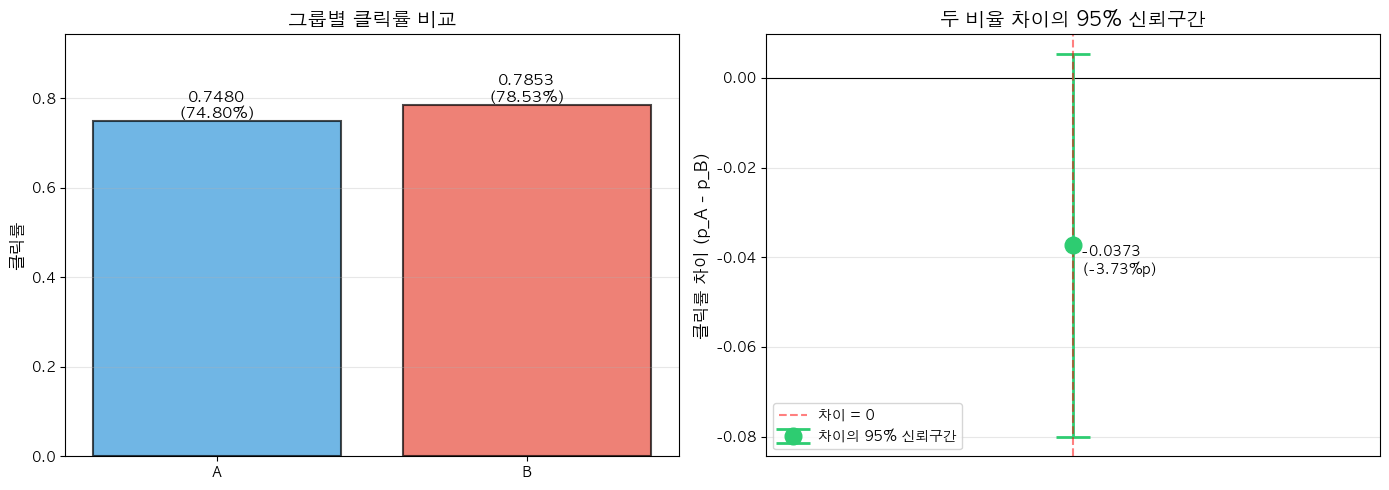

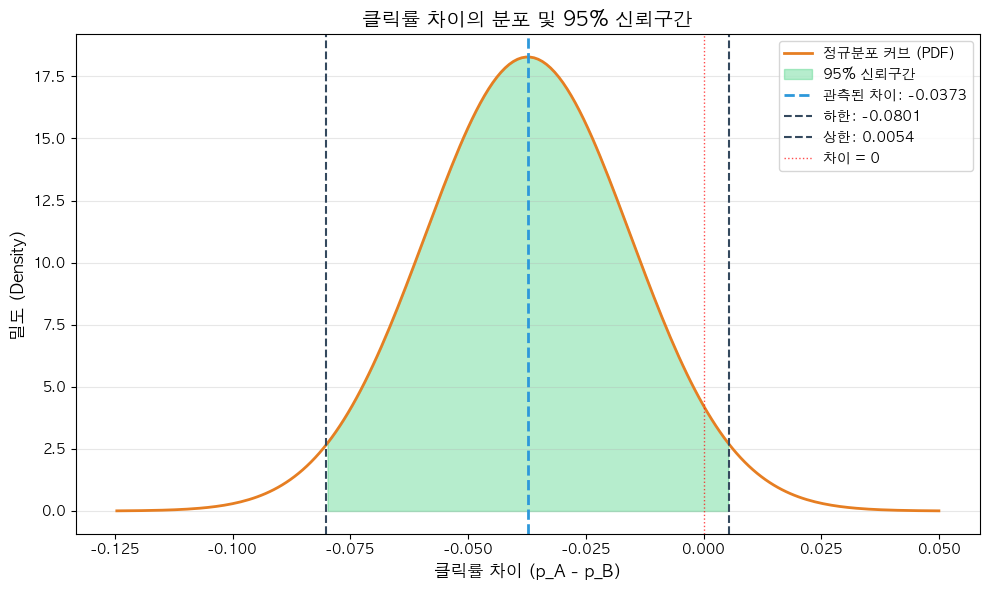

In [87]:
# 시각화: 그룹별 클릭률 비교 및 신뢰구간
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. 막대 그래프: 그룹별 클릭률 비교
groups = ["A", "B"]
click_rates = [click_rate_a, click_rate_b]
colors = ["#3498db", "#e74c3c"]

bars = axes[0].bar(groups, click_rates, color=colors, alpha=0.7, edgecolor="black", linewidth=1.5)
axes[0].set_ylabel("클릭률", fontsize=12)
axes[0].set_title("그룹별 클릭률 비교", fontsize=14, fontweight="bold")
axes[0].set_ylim([0, max(click_rates) * 1.2])
axes[0].grid(axis="y", alpha=0.3)

# 막대 위에 값 표시
for i, (bar, rate) in enumerate(zip(bars, click_rates)):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f"{rate:.4f}\n({rate*100:.2f}%)",
                ha="center", va="bottom", fontsize=11, fontweight="bold")

# 2. 신뢰구간 시각화: 클릭률 차이의 95% 신뢰구간
axes[1].axhline(y=0, color="black", linestyle="-", linewidth=0.8)
axes[1].errorbar([0], [diff], yerr=[[abs(diff - ci_lower)], [abs(ci_upper - diff)]], 
                fmt="o", markersize=12, capsize=12, capthick=2, 
                color="#2ecc71", linewidth=2, label="차이의 95% 신뢰구간")
axes[1].axvline(x=0, color="red", linestyle="--", linewidth=1.5, alpha=0.5, label="차이 = 0")
axes[1].set_xlim([-0.5, 0.5])
axes[1].set_ylabel("클릭률 차이 (p_A - p_B)", fontsize=12)
axes[1].set_title("두 비율 차이의 95% 신뢰구간", fontsize=14, fontweight="bold")
axes[1].grid(axis="y", alpha=0.3)
axes[1].legend(fontsize=10)
axes[1].set_xticks([])

# 신뢰구간 값 표시
axes[1].text(0, diff, f"  {diff:.4f}\n  ({diff*100:.2f}%p)", 
            ha="left", va="bottom" if diff > 0 else "top", fontsize=10, fontweight="bold")

plt.tight_layout()
plt.show()

# 추가 시각화: 정규분포 커브와 신뢰구간
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

mu = diff  # 관측된 클릭률 차이
sigma = se_diff
x_range = np.linspace(mu - 4*sigma, mu + 4*sigma, 200)
pdf = norm.pdf(x_range, loc=mu, scale=sigma)

# 정규분포 커브
ax.plot(x_range, pdf, color='#e67e22', linewidth=2, label="정규분포 커브 (PDF)")
ax.fill_between(x_range, 0, pdf, where=(x_range >= ci_lower) & (x_range <= ci_upper),
                color="#2ecc71", alpha=0.35, label="95% 신뢰구간")
ax.axvline(mu, color='#2d98da', linestyle='--', linewidth=2, label=f"관측된 차이: {diff:.4f}")
ax.axvline(ci_lower, color="#34495e", linestyle="--", linewidth=1.5, label=f"하한: {ci_lower:.4f}")
ax.axvline(ci_upper, color="#34495e", linestyle="--", linewidth=1.5, label=f"상한: {ci_upper:.4f}")
ax.axvline(0, color="red", linestyle=":", linewidth=1, alpha=0.7, label="차이 = 0")

ax.set_xlabel("클릭률 차이 (p_A - p_B)", fontsize=12)
ax.set_ylabel("밀도 (Density)", fontsize=12)
ax.set_title("클릭률 차이의 분포 및 95% 신뢰구간", fontsize=14, fontweight="bold")
ax.grid(axis="y", alpha=0.3)
ax.legend(fontsize=10, loc='best')

plt.tight_layout()
plt.show()

## 📊 분석 결과 요약

### 주요 발견사항
위의 분석 결과를 바탕으로 다음 사항을 확인하세요:

1. **클릭률 비교**
   - A그룹과 B그룹의 클릭률을 비교
   - 클릭률 차이 계산

2. **통계적 유의성**
   - p-value와 유의수준(α = 0.05) 비교
   - 귀무가설 기각 여부 확인

3. **신뢰구간**
   - 95% 신뢰구간 범위 확인
   - 신뢰구간이 0을 포함하는지 여부 확인

### 실무적 해석 가이드
- **p-value < 0.05**: 두 그룹 간 클릭률 차이가 통계적으로 유의미함
- **p-value ≥ 0.05**: 두 그룹 간 클릭률 차이가 통계적으로 유의미하지 않음 (우연에 의한 차이일 수 있음)
- **신뢰구간이 0을 포함**: 차이가 유의미하지 않을 가능성이 높음
- **신뢰구간이 0을 포함하지 않음**: 차이가 유의미할 가능성이 높음

### 다음 단계
1. 통계적으로 유의미한 차이가 있다면, 더 높은 클릭률을 보인 버전을 선택
2. 통계적으로 유의미한 차이가 없다면, 추가 실험이나 더 큰 샘플 크기 고려
3. 비즈니스 목표와 결합하여 최종 결정

---

## 4-2단계: 가설검정 (Z-test)

신뢰구간과 함께 가설검정을 통해 통계적 유의성을 확인합니다.

In [ ]:
# ============================================================================
# 4-2단계: 가설검정 (Z-test)
# ============================================================================

# 가설 설정
# H0: p_a = p_b (두 그룹의 클릭률이 같다)
# H1: p_a ≠ p_b (두 그룹의 클릭률이 다르다)

# 합동 비율(pooled proportion) 계산
# 두 그룹을 합쳐서 전체 클릭률 계산
p_pooled = (x_a + x_b) / (n_a + n_b)

# 표준오차 계산 (합동 비율 사용)
# 가설검정에서는 귀무가설이 참일 때의 표준오차를 사용
se_pooled = np.sqrt(p_pooled * (1 - p_pooled) * (1/n_a + 1/n_b))

# Z 통계량 계산
# Z = (p_a - p_b) / SE_pooled
z_statistic = (p_a - p_b) / se_pooled

# p-value 계산 (양측검정)
# 양측검정: 두 그룹의 차이가 양수든 음수든 관심이 있음
p_value = 2 * (1 - stats.norm.cdf(abs(z_statistic)))

print("=" * 70)
print("🔬 두 비율 차이에 대한 가설검정 (Z-test)")
print("=" * 70)
print(f"귀무가설(H0): p_A = p_B (두 그룹의 클릭률이 같다)")
print(f"대립가설(H1): p_A ≠ p_B (두 그룹의 클릭률이 다르다)")
print(f"\n합동 비율 (p_pooled): {p_pooled:.4f}")
print(f"표준오차 (합동, SE_pooled): {se_pooled:.4f}")
print(f"Z 통계량: {z_statistic:.4f}")
print(f"p-value: {p_value:.6f}")

# 유의수준 0.05에서의 해석
alpha = 0.05
print(f"\n유의수준 α = {alpha}")

print("\n" + "=" * 70)
print("📋 가설검정 결과 해석")
print("=" * 70)
if p_value < alpha:
    print(f"✅ 결론: p-value ({p_value:.6f}) < α ({alpha})이므로 귀무가설을 기각합니다.")
    print("→ A그룹과 B그룹의 클릭률 차이는 통계적으로 유의미합니다.")
    if diff > 0:
        print(f"→ A그룹의 클릭률이 B그룹보다 통계적으로 유의미하게 높습니다.")
    else:
        print(f"→ B그룹의 클릭률이 A그룹보다 통계적으로 유의미하게 높습니다.")
else:
    print(f"❌ 결론: p-value ({p_value:.6f}) ≥ α ({alpha})이므로 귀무가설을 기각하지 못합니다.")
    print("→ A그룹과 B그룹의 클릭률 차이는 통계적으로 유의미하지 않습니다.")
    print("→ 관측된 차이는 우연에 의한 것일 수 있습니다.")

print("\n✅ 가설검정 완료")

---

## 5단계: 결과 요약 (인사이트 도출)

분석 결과를 요약하고 실무적 인사이트를 도출합니다.

In [ ]:
# ============================================================================
# 5단계: 결과 요약 및 인사이트 도출
# ============================================================================

print("=" * 70)
print("📊 A/B 테스트 분석 결과 요약")
print("=" * 70)

print("\n[1] 기초 통계")
print(f"   - A그룹 클릭률: {click_rate_a:.4f} ({click_rate_a*100:.2f}%)")
print(f"   - B그룹 클릭률: {click_rate_b:.4f} ({click_rate_b*100:.2f}%)")
print(f"   - 클릭률 차이: {abs(click_rate_a - click_rate_b):.4f} ({abs(click_rate_a - click_rate_b)*100:.2f}%p)")

print("\n[2] 신뢰구간")
print(f"   - 95% 신뢰구간: [{ci_lower:.4f}, {ci_upper:.4f}]")
print(f"   - 신뢰구간 해석: ", end="")
if ci_lower <= 0 <= ci_upper:
    print("0을 포함하므로 차이가 유의미하지 않을 수 있음")
else:
    print("0을 포함하지 않으므로 차이가 유의미함")

print("\n[3] 가설검정")
print(f"   - p-value: {p_value:.6f}")
print(f"   - 유의수준: α = 0.05")
print(f"   - 결론: ", end="")
if p_value < 0.05:
    print("통계적으로 유의미한 차이 있음")
else:
    print("통계적으로 유의미한 차이 없음")

print("\n" + "=" * 70)
print("💡 실무적 인사이트")
print("=" * 70)

# 인사이트 도출
if p_value < 0.05:
    if click_rate_a > click_rate_b:
        print("✅ A그룹이 B그룹보다 통계적으로 유의미하게 높은 클릭률을 보입니다.")
        print("   → 권장사항: A 버전을 선택하는 것이 적절합니다.")
    else:
        print("✅ B그룹이 A그룹보다 통계적으로 유의미하게 높은 클릭률을 보입니다.")
        print("   → 권장사항: B 버전을 선택하는 것이 적절합니다.")
else:
    print("⚠️  두 그룹 간 클릭률 차이가 통계적으로 유의미하지 않습니다.")
    print("   → 권장사항:")
    print("     1. 추가 실험을 통해 더 많은 데이터 수집")
    print("     2. 샘플 크기를 늘려 통계적 검정력 향상")
    print("     3. 현재는 두 버전 모두 유사한 성능으로 판단 가능")

print("\n[추가 고려사항]")
print("   - 비즈니스 목표와 결합하여 최종 결정")
print("   - 구현 비용, 사용자 경험 등 정성적 요소 고려")
print("   - 장기적인 효과 모니터링 필요")

print("\n✅ 결과 요약 완료")

---

## 📈 추가 시각화: 정규분포 커브와 신뢰구간

클릭률 차이의 분포를 정규분포 커브로 시각화합니다.

In [ ]:
# ============================================================================
# 추가 시각화: 정규분포 커브와 신뢰구간
# ============================================================================

# 정규분포 커브 생성
mu = diff  # 관측된 클릭률 차이 (평균)
sigma = se_diff  # 표준오차 (표준편차)
x_range = np.linspace(mu - 4*sigma, mu + 4*sigma, 200)
pdf = norm.pdf(x_range, loc=mu, scale=sigma)

# 시각화
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# 정규분포 커브
ax.plot(x_range, pdf, color='#e67e22', linewidth=2, label="정규분포 커브 (PDF)")

# 95% 신뢰구간 영역 표시
ax.fill_between(x_range, 0, pdf, where=(x_range >= ci_lower) & (x_range <= ci_upper),
                color="#2ecc71", alpha=0.35, label="95% 신뢰구간")

# 주요 지점 표시
ax.axvline(mu, color='#2d98da', linestyle='--', linewidth=2, 
           label=f"관측된 차이: {diff:.4f}")
ax.axvline(ci_lower, color="#34495e", linestyle="--", linewidth=1.5, 
           label=f"하한: {ci_lower:.4f}")
ax.axvline(ci_upper, color="#34495e", linestyle="--", linewidth=1.5, 
           label=f"상한: {ci_upper:.4f}")
ax.axvline(0, color="red", linestyle=":", linewidth=1.5, alpha=0.7, 
           label="차이 = 0")

ax.set_xlabel("클릭률 차이 (p_A - p_B)", fontsize=12, fontweight="bold")
ax.set_ylabel("밀도 (Density)", fontsize=12, fontweight="bold")
ax.set_title("클릭률 차이의 분포 및 95% 신뢰구간", fontsize=14, fontweight="bold")
ax.grid(axis="y", alpha=0.3)
ax.legend(fontsize=10, loc='best')

plt.tight_layout()
plt.show()

print("✅ 추가 시각화 완료")

---

## ✅ 프로젝트 완료 체크리스트

### 분석 완료 항목
- [x] 1단계: 주제 선택 (A/B 테스트)
- [x] 2단계: 데이터 구조 이해 (변수 타입, 0/1 의미)
- [x] 3단계: 기초 통계 & 시각화 (비율 계산, 막대그래프)
- [x] 4단계: 신뢰구간 계산 (95% CI 및 차이 해석)
- [x] 5단계: 결과 요약 (인사이트 도출)

### 산출물 준비
- [x] 파이썬 노트북 (.ipynb): 분석 코드 및 주석 포함 ✅
- [ ] 요약 슬라이드 (1~2장): 핵심 결과 및 결론 위주
- [ ] 팀별 발표 (3~5분): 분석 과정과 결론 공유

### 발표 준비 포인트
1. **문제 정의**: A/B 테스트를 통한 클릭률 비교
2. **데이터**: 사용 데이터 및 변수 설명
3. **분석 방법**: 비율 비교, 신뢰구간, 가설검정
4. **주요 결과**: 클릭률 차이, 통계적 유의성
5. **결론 및 권장사항**: 실무적 인사이트

---

**프로젝트 완료! 🎉**